In [1]:
import os
from numpy import genfromtxt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.signal import resample

from data_organizer_Kfall import DataOrganizer
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from utils import train, test


# Data Loader

In [2]:
# mac
#sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
#label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.1
num_window_fall_data = 50
num_window_not_fall_data = 5

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...


In [3]:

in_channels = data.shape[1]
print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', data.shape)

in_channels:  50
data.shape:  (25743, 50, 9)


In [4]:
label = label.astype(np.int64)
# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.05, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)


X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)


# print datatype of X_train_tensor
X_train_tensor = X_train_tensor.double()
print('X_train_tensor.dtype: ', X_train_tensor.dtype)
X_test = X_train_tensor.double()


# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

B_size:  25020
A_size:  723
(58, 50, 9)
X_train_tensor.dtype:  torch.float64
Using cuda device


# Hyperparameters

In [5]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
patience = 5

# ConvLSTM

In [6]:
class ConvLSTM(nn.Module):
    def __init__(self):
        super(ConvLSTM, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=9, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2))
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2))
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2))

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)

        self.fc = nn.Linear(64, 2)  # No need for softmax here when using nn.CrossEntropyLoss
    
    def forward(self, x):
        # Convolutional layers
        x = x.transpose(1, 2)  # Transpose to have the correct dimensions for Conv1d (batch, channels, length)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Prepare for LSTM
        x = x.transpose(1, 2)  # Transpose back to (batch, seq_len, features)
        
        # LSTM layers
        x, _ = self.lstm1(x)  # Only take the output, ignore hidden states
        x = self.dropout1(x)
        x, _ = self.lstm2(x)  # Only take the output, ignore hidden states
        x = self.dropout2(x)
        
        # Take the outputs of the last time step
        x = x[:, -1, :]
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

In [7]:

# Create an instance of the model
model_ConvLSTM = ConvLSTM()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ConvLSTM.parameters(), lr=learning_rate)
# Initialize the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=patience, verbose=True)
print(f"Model structure: {model_ConvLSTM}\n\n")
for name, param in model_ConvLSTM.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: ConvLSTM(
  (conv1): Sequential(
    (0): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm1): LSTM(64, 64, batch_first=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (lstm2): LSTM(64, 64, batch_fir

In [8]:
train(train_dataloader, model_ConvLSTM, loss_fn, optimizer,val_dataloader, 
           patience=patience, scheduler=scheduler, epochs=epochs, device=device, B_size=B_size, A_size=A_size)

Epoch 0:
loss: 1.134259  [   64/23232]
loss: 0.382163  [ 6464/23232]
loss: 0.358830  [12864/23232]
loss: 0.114418  [19264/23232]
Validation Error: 
 Accuracy: 97.4%, Avg loss: 0.058425 

Epoch 1:
loss: 0.370029  [   64/23232]
loss: 0.525420  [ 6464/23232]
loss: 0.049795  [12864/23232]
loss: 0.075194  [19264/23232]
Validation Error: 
 Accuracy: 97.7%, Avg loss: 0.050454 

Epoch 2:
loss: 0.205643  [   64/23232]
loss: 0.267904  [ 6464/23232]
loss: 0.102905  [12864/23232]
loss: 0.385321  [19264/23232]
Validation Error: 
 Accuracy: 97.7%, Avg loss: 0.050829 

Epoch 3:
loss: 0.164040  [   64/23232]
loss: 0.087281  [ 6464/23232]
loss: 0.049689  [12864/23232]
loss: 0.098493  [19264/23232]
Validation Error: 
 Accuracy: 97.9%, Avg loss: 0.044533 

Epoch 4:
loss: 0.185709  [   64/23232]
loss: 0.007344  [ 6464/23232]
loss: 0.174217  [12864/23232]
loss: 0.169936  [19264/23232]
Validation Error: 
 Accuracy: 97.9%, Avg loss: 0.050823 

Epoch 5:
loss: 0.051107  [   64/23232]
loss: 0.131224  [ 6464/232

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.318213 

 Label 0
    accuracy	0.931
 specificity	0.900
 sensitivity	0.964
 Label 1
    accuracy	0.931
 specificity	0.964
 sensitivity	0.900
[[27  1]
 [ 3 27]]


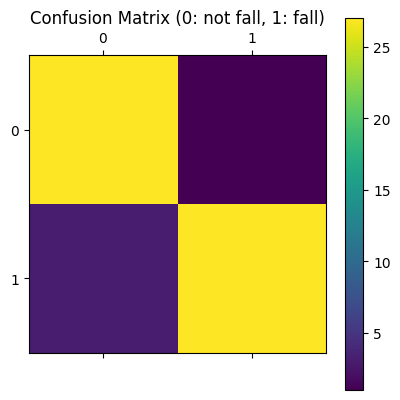

In [9]:
# final test
test(test_dataloader, model_ConvLSTM, loss_fn, device=device)


# ResNet24

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.convr = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=1)
    def forward(self, input):
        residual = self.convr(input)
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x += residual
        x = self.relu3(x)
        return x

class IdentityBlock(nn.Module):
    def __init__(self, in_channels):
        super(IdentityBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
    def forward(self, input):
        
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x += residual
        x = self.relu3(x)
        return x

class ResNet24(nn.Module):
    def __init__(self):
        super(ResNet24, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=9, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.pool1 = nn.MaxPool1d(2)
        
        self.convblk1 = ConvBlock(64)
        self.convblk2 = ConvBlock(64)
        self.identityblk1 = IdentityBlock(64)
        self.convblk3 = ConvBlock(64)
        self.identityblk2 = IdentityBlock(64)
        self.convblk4 = ConvBlock(64)
        self.identityblk3 = IdentityBlock(64)
        
        self.pool2 = nn.AvgPool1d(2)
        
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(in_features=704, out_features=2),
        #                        nn.Softmax()
                                )
    
    def forward(self, x):
        x = x.transpose(1, 2)  # Transpose to have the correct dimensions for Conv1d (batch, channels, length)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.convblk1(x)
        x = self.convblk2(x)
        x = self.identityblk1(x)
        x = self.convblk3(x)
        x = self.identityblk2(x)
        x = self.convblk4(x)
        x = self.identityblk3(x)
        x = self.pool2(x)
        x = self.fc(x)
        return x

In [11]:
#from models.ResNet24 import ResNet24

# Create an instance of the model
model_resnet = ResNet24().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=learning_rate)
# Initialize the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=patience, verbose=True)
print(f"Model structure: {model_resnet}\n\n")
for name, param in model_resnet.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: ResNet24(
  (conv1): Conv1d(9, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblk1): ConvBlock(
    (conv1): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=same)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (convr): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (convblk2): ConvBlock(
    (conv1): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running

In [12]:
train(train_dataloader, model_resnet, loss_fn, optimizer,val_dataloader, 
        patience=patience, scheduler=scheduler, device=device, epochs=epochs, B_size=B_size, A_size=A_size)

Epoch 0:
loss: 1.096105  [   64/23232]
loss: 0.010406  [ 6464/23232]
loss: 0.106687  [12864/23232]
loss: 0.096606  [19264/23232]
Validation Error: 
 Accuracy: 97.5%, Avg loss: 0.066864 

Epoch 1:
loss: 0.070460  [   64/23232]
loss: 0.045280  [ 6464/23232]
loss: 0.040948  [12864/23232]
loss: 0.272570  [19264/23232]
Validation Error: 
 Accuracy: 97.0%, Avg loss: 0.076399 

Epoch 2:
loss: 0.254746  [   64/23232]
loss: 0.027418  [ 6464/23232]
loss: 0.155882  [12864/23232]
loss: 0.209149  [19264/23232]
Validation Error: 
 Accuracy: 97.9%, Avg loss: 0.049656 

Epoch 3:
loss: 0.080304  [   64/23232]
loss: 0.047344  [ 6464/23232]
loss: 0.297360  [12864/23232]
loss: 0.093212  [19264/23232]
Validation Error: 
 Accuracy: 98.3%, Avg loss: 0.047004 

Epoch 4:
loss: 0.012315  [   64/23232]
loss: 0.307595  [ 6464/23232]
loss: 0.060982  [12864/23232]
loss: 0.008558  [19264/23232]
Validation Error: 
 Accuracy: 98.1%, Avg loss: 0.048525 

Epoch 5:
loss: 0.324041  [   64/23232]
loss: 0.031715  [ 6464/232

Test Error: 
 Accuracy: 79.3%, Avg loss: 0.564428 

 Label 0
    accuracy	0.793
 specificity	0.633
 sensitivity	0.964
 Label 1
    accuracy	0.793
 specificity	0.964
 sensitivity	0.633
[[27  1]
 [11 19]]


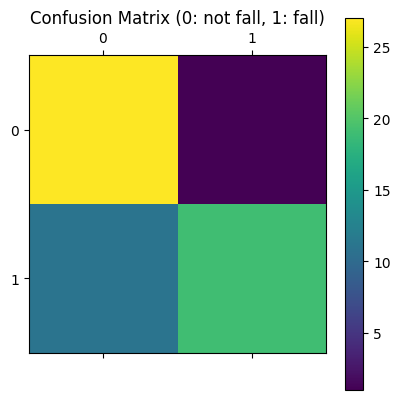

In [13]:
# final test
test(test_dataloader, model_resnet, loss_fn, device=device)

# TinyFallNet

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.convr = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=1)
    def forward(self, input):
        residual = self.convr(input)
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x += residual
        x = self.relu3(x)
        return x

class TinyFallNet(nn.Module):
    def __init__(self):
        super(TinyFallNet, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=9, out_channels=64, kernel_size=3)
        self.pool1 = nn.MaxPool1d(2)
        
        self.convblk1 = ConvBlock(64)
        self.convblk2 = ConvBlock(64)
        self.convblk3 = ConvBlock(64)
        self.convblk4 = ConvBlock(64)
        
        self.pool2 = nn.AvgPool1d(2)
        
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(in_features=768, out_features=2),
                                nn.Softmax())
    
    def forward(self, x):
        x = x.transpose(1, 2)  # Transpose to have the correct dimensions for Conv1d (batch, channels, length)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.convblk1(x)
        x = self.convblk2(x)
        x = self.convblk3(x)
        x = self.convblk4(x)
        x = self.pool2(x)
        x = self.fc(x)
        return x

In [15]:
#from models.TinyFallNet import TinyFallNet

# Create an instance of the model
model_tinyFallNet = TinyFallNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tinyFallNet.parameters(), lr=learning_rate)
# Initialize the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=patience, verbose=True)

print(f"Model structure: {model_tinyFallNet}\n\n")
for name, param in model_tinyFallNet.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: TinyFallNet(
  (conv1): Conv1d(9, 64, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblk1): ConvBlock(
    (conv1): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=same)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (convr): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (convblk2): ConvBlock(
    (conv1): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv1d(1

In [16]:
train(train_dataloader, model_tinyFallNet, loss_fn, optimizer,val_dataloader, 
        patience=patience, scheduler=scheduler, device=device, epochs=epochs, B_size=B_size, A_size=A_size)

Epoch 0:
loss: 1.259295  [   64/23232]


g:\python\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 0.501584  [ 6464/23232]
loss: 0.313263  [12864/23232]
loss: 0.706318  [19264/23232]
Validation Error: 
 Accuracy: 97.1%, Avg loss: 0.340608 

Epoch 1:
loss: 0.313266  [   64/23232]
loss: 0.313266  [ 6464/23232]
loss: 0.706313  [12864/23232]
loss: 0.501585  [19264/23232]
Validation Error: 
 Accuracy: 97.1%, Avg loss: 0.340606 

Epoch 2:
loss: 0.927450  [   64/23232]
loss: 0.501584  [ 6464/23232]
loss: 0.313263  [12864/23232]
loss: 1.164999  [19264/23232]
Validation Error: 
 Accuracy: 97.1%, Avg loss: 0.340606 

Epoch 3:
loss: 0.313263  [   64/23232]
loss: 0.313262  [ 6464/23232]
loss: 0.927452  [12864/23232]
loss: 0.706312  [19264/23232]
Validation Error: 
 Accuracy: 97.1%, Avg loss: 0.340606 

Epoch 4:
loss: 0.706312  [   64/23232]
loss: 0.927452  [ 6464/23232]
loss: 0.501584  [12864/23232]
loss: 0.501583  [19264/23232]
Validation Error: 
 Accuracy: 97.1%, Avg loss: 0.340606 

Epoch 5:
loss: 1.164999  [   64/23232]
loss: 0.501584  [ 6464/23232]
loss: 0.313262  [12864/23232]
loss:

Test Error: 
 Accuracy: 48.3%, Avg loss: 0.830503 

 Label 0
    accuracy	0.483
 specificity	0.000
 sensitivity	1.000
 Label 1
    accuracy	0.483
 specificity	1.000
 sensitivity	0.000
[[28  0]
 [30  0]]


g:\python\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


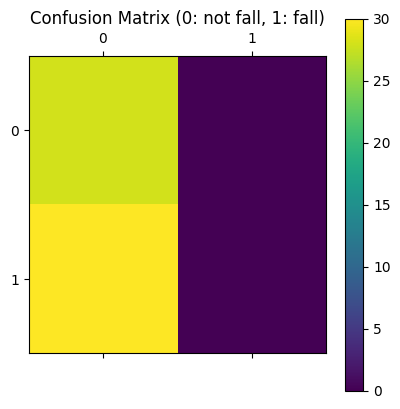

In [19]:
# final test
test(test_dataloader, model_tinyFallNet, loss_fn, device=device)

# Summary

ConvLSTM
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.318213 

 Label 0
    accuracy	0.931
 specificity	0.900
 sensitivity	0.964
 Label 1
    accuracy	0.931
 specificity	0.964
 sensitivity	0.900
[[27  1]
 [ 3 27]]


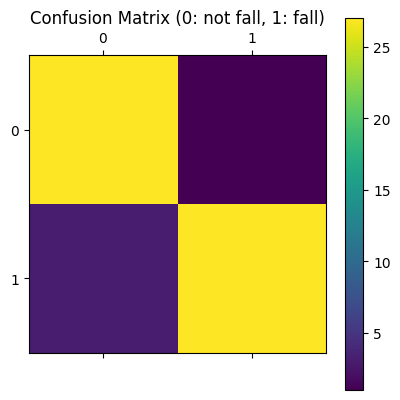

In [25]:
# ConvLSTM
print('ConvLSTM')
test(test_dataloader, model_ConvLSTM, loss_fn, device=device)

ResNet24
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.564428 

 Label 0
    accuracy	0.793
 specificity	0.633
 sensitivity	0.964
 Label 1
    accuracy	0.793
 specificity	0.964
 sensitivity	0.633
[[27  1]
 [11 19]]


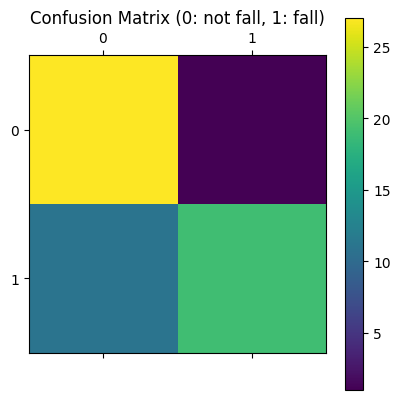

In [24]:
# ResNet24
print('ResNet24')
test(test_dataloader, model_resnet, loss_fn, device=device)

TinyFallNet
Test Error: 
 Accuracy: 48.3%, Avg loss: 0.830503 

 Label 0
    accuracy	0.483
 specificity	0.000
 sensitivity	1.000
 Label 1
    accuracy	0.483
 specificity	1.000
 sensitivity	0.000
[[28  0]
 [30  0]]


g:\python\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


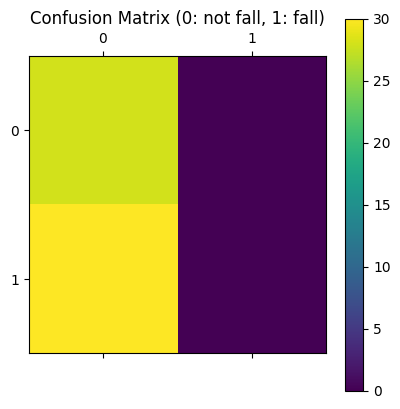

In [26]:
# TinyFallNet
print('TinyFallNet')
test(test_dataloader, model_tinyFallNet, loss_fn, device=device)